# Part A: Cobb-Douglas Production Function

In [3]:
library(tidyverse)
library(stargazer)
library(modelsummary)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.1     v tibble    3.2.1
v lubridate 1.9.3     v tidyr     1.3.1
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Please cite as: 


 Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 




# Q1/Q2

Null values in rf and salinity columns after filling:
      rf salinity 
       0        0 



Call:
lm(formula = log_production ~ log_area + log_fertilizer + log_irrigated + 
    log_unirrigated + rf + salinity, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.54456 -0.25571  0.04671  0.29304  0.95610 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.2739267  0.3007548   0.911    0.363    
log_area         1.0370348  0.0419793  24.703  < 2e-16 ***
log_fertilizer  -0.0143493  0.0255010  -0.563    0.574    
log_irrigated    0.0074766  0.0615963   0.121    0.904    
log_unirrigated -0.0497873  0.0604751  -0.823    0.411    
rf              -0.0011525  0.0002715  -4.245 3.31e-05 ***
salinity         0.0014665  0.0017362   0.845    0.399    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4486 on 206 degrees of freedom
Multiple R-squared:  0.9603,	Adjusted R-squared:  0.9591 
F-statistic: 830.1 on 6 and 206 DF,  p-value: < 2.2e-16


`geom_smooth()` using formula = 'y ~ x'


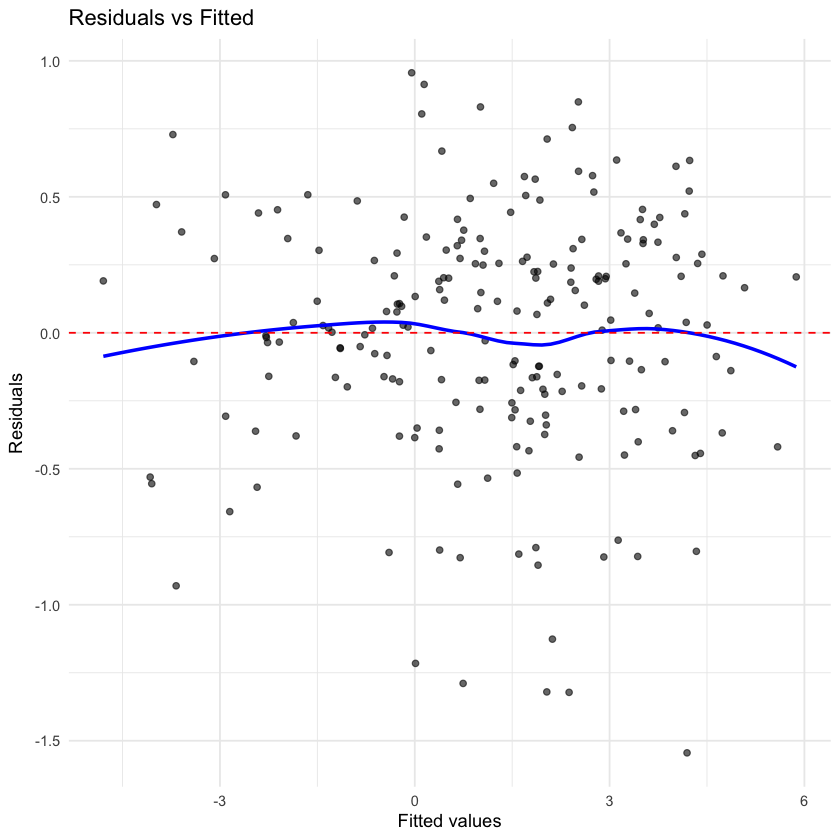

In [4]:

options(readr.show_col_types = FALSE)
df <- read_csv("./Seasonal_Rf_avg.csv")

df <- df %>%
  mutate(across(where(is.numeric), ~ifelse(is.na(.), mean(., na.rm = TRUE), .)))


cat("Null values in rf and salinity columns after filling:\n")
print(colSums(is.na(df[c("rf", "salinity")])))


names(df) <- str_trim(names(df))


df <- df %>%
  mutate(
    total_fertilizer = nitrogenconsumptiontonnes + phosphateconsumptiontonnes + potashconsumptiontonnes,
    unirrigated_area = area1000hectares - irrigatedarea1000hectares
  )

df <- df %>%
  mutate(
    irrigated_plus1 = irrigatedarea1000hectares + 1,
    unirrigated_plus1 = unirrigated_area + 1
  )


df <- df %>%
  mutate(
    log_production = log(production1000tonnes),
    log_area = log(area1000hectares),
    log_fertilizer = log(total_fertilizer),
    log_irrigated = log(irrigated_plus1),
    log_unirrigated = log(unirrigated_plus1)
  )


model <- lm(
  log_production ~ log_area + log_fertilizer + log_irrigated + log_unirrigated + rf + salinity,
  data = df
)

summary(model)


ggplot(data = data.frame(fitted = model$fitted.values, resid = model$residuals), aes(x = fitted, y = resid)) +
  geom_point(alpha = 0.6) +
  geom_smooth(method = "loess", se = FALSE, color = "blue") +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  labs(
    title = "Residuals vs Fitted",
    x = "Fitted values",
    y = "Residuals"
  ) +
  theme_minimal()

## Q3
Are there any outliers and/or influential observations? What are the collinearity diagnostics?
How do they influence the estimation and interpretation?


Write answer here (Q3)

DFFITS Threshold: 0.3357
Number of potentially influential observations (based on DFFITS): 17

Potentially influential observations (first 5 based on DFFITS):
# A tibble: 5 x 23
  crop      area1000hectares production1000tonnes irrigatedarea1000hectares
  <chr>                <dbl>                <dbl>                     <dbl>
1 Pigeonpea             2.28                0.580                    0.022 
2 Pigeonpea            72.8                14.1                      0.0300
3 Pigeonpea            11.0                 2.87                     3.34  
4 Pigeonpea           286.                176.                      31.2   
5 Pigeonpea             2                   1.3                      0     
# i 19 more variables: districtcode <dbl>, year <dbl>, statecode <dbl>,
#   state <chr>, nitrogenconsumptiontonnes <dbl>,
#   phosphateconsumptiontonnes <dbl>, potashconsumptiontonnes <dbl>,
#   district <chr>, rf <dbl>, salinity <dbl>, total_fertilizer <dbl>,
#   unirrigated_area <dbl>, i

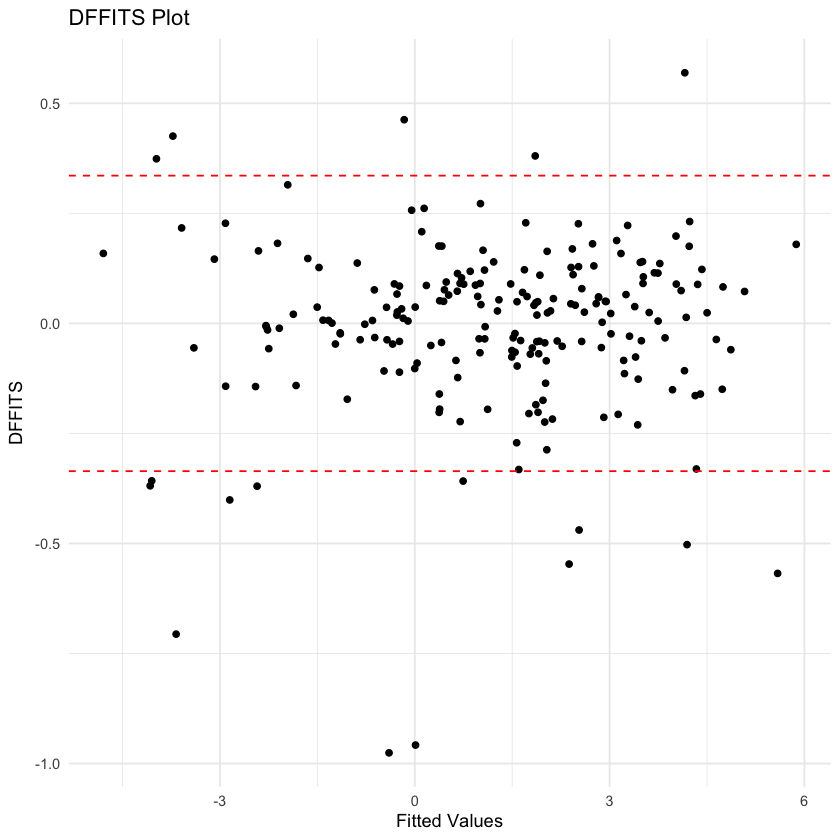

In [5]:


influence <- influence.measures(model)
hat_values <- hatvalues(model)
residuals_std <- rstandard(model)
dffits <- residuals_std * sqrt(hat_values / (1 - hat_values))

p <- length(coef(model)) - 1
n <- nrow(df)
dffits_threshold <- 2 * sqrt(p / n)

influential_indices <- which(abs(dffits) > dffits_threshold)
influential_observations <- df[influential_indices, ]

cat(sprintf("DFFITS Threshold: %.4f\n", dffits_threshold))
cat(sprintf("Number of potentially influential observations (based on DFFITS): %d\n", length(influential_indices)))

if (length(influential_indices) > 0) {
  cat("\nPotentially influential observations (first 5 based on DFFITS):\n")
  print(head(influential_observations, 5))
}

ggplot(data = data.frame(Fitted = fitted(model), DFFITS = dffits), aes(x = Fitted, y = DFFITS)) +
  geom_point() +
  geom_hline(yintercept = dffits_threshold, color = "red", linetype = "dashed") +
  geom_hline(yintercept = -dffits_threshold, color = "red", linetype = "dashed") +
  labs(title = "DFFITS Plot", x = "Fitted Values", y = "DFFITS") +
  theme_minimal()

calculate_vif <- function(X) {
  vif_values <- numeric(ncol(X))
  names(vif_values) <- colnames(X)
  
  for (i in seq_along(vif_values)) {
    response <- X[, i]
    predictors <- X[, -i, drop = FALSE]
    model_i <- lm(response ~ ., data = as.data.frame(predictors))
    r_squared <- summary(model_i)$r.squared
    vif_values[i] <- 1 / (1 - r_squared)
  }
  
  return(data.frame(Feature = names(vif_values), VIF = vif_values))
}

X <- model.matrix(model)[, -1]
X_df <- as.data.frame(X)

vif_data <- calculate_vif(X_df)

cat("\nCollinearity Diagnostics (Variance Inflation Factors - VIF):\n")
print(vif_data)

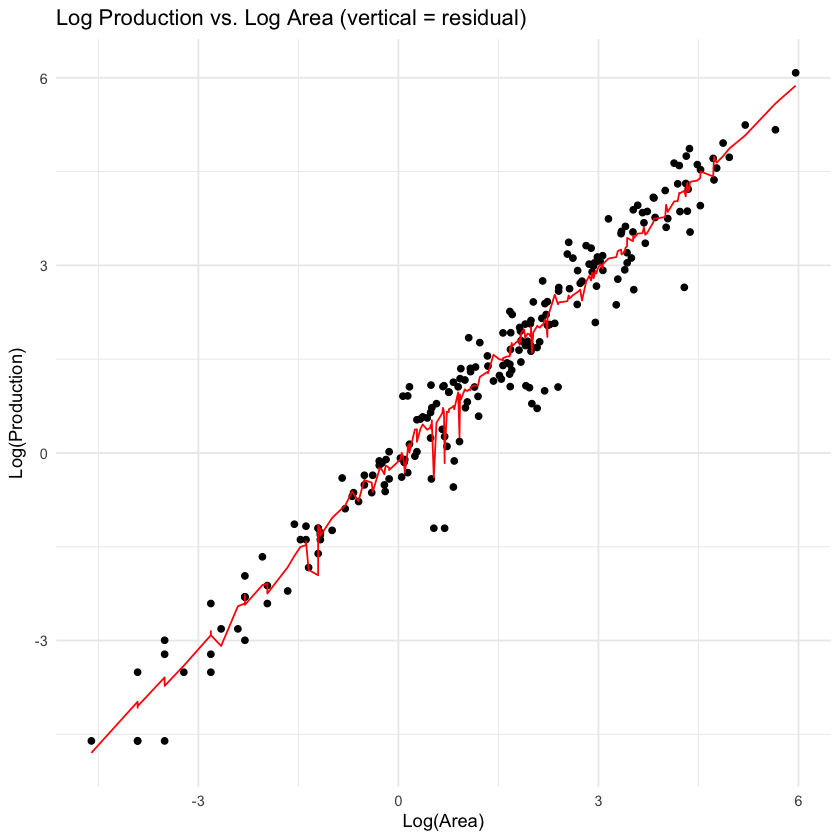

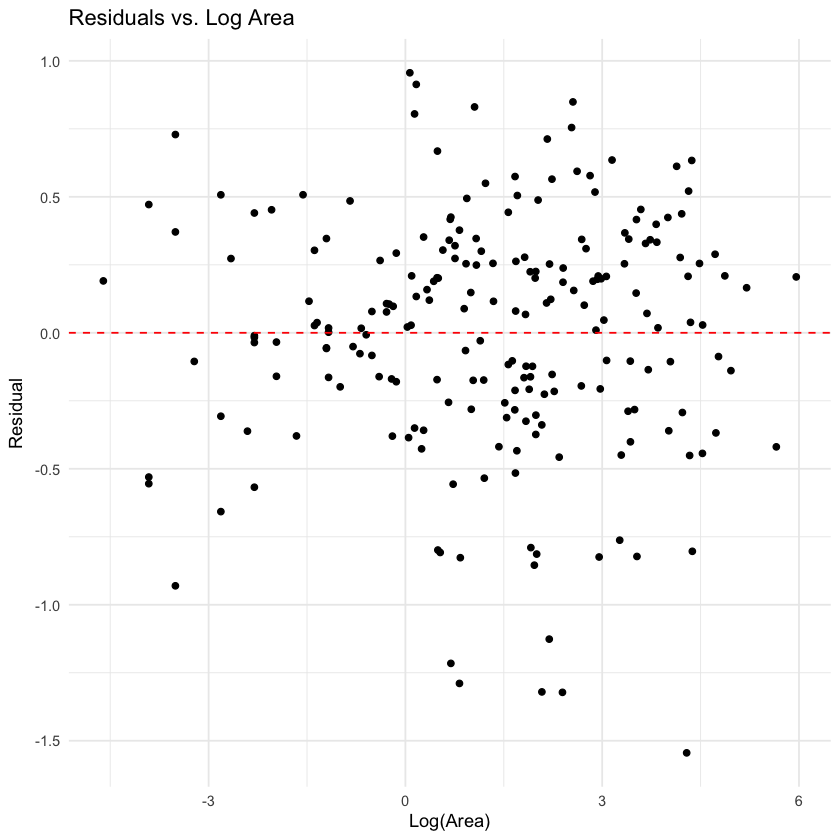

Sum of residuals:  0 


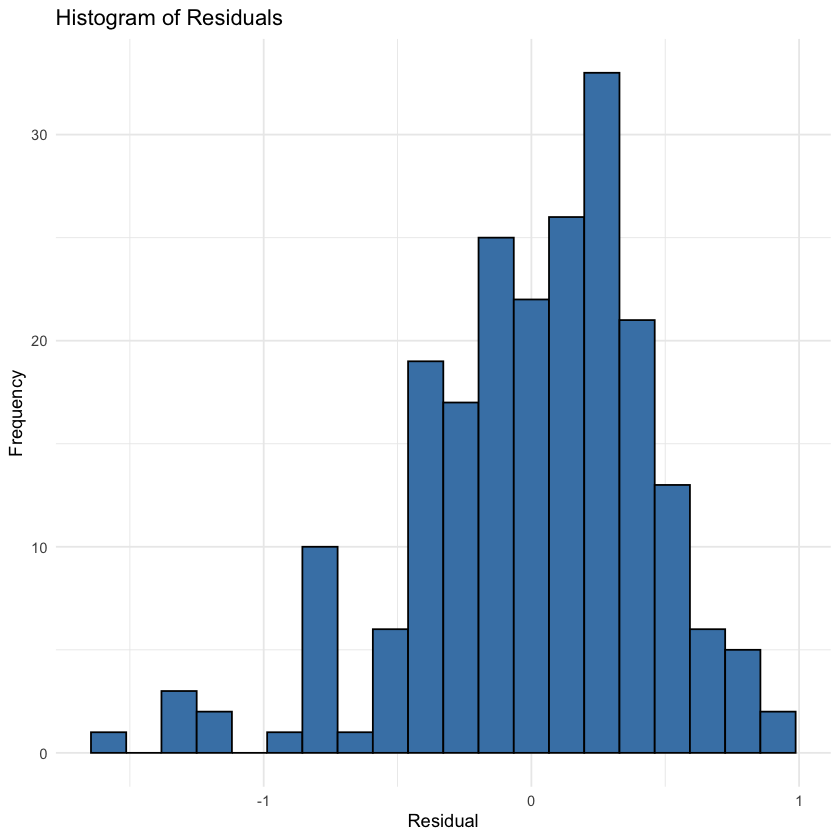

In [11]:
#Q4
x_ar <- df$log_area
y_prod <- df$log_production
fitted <- model$fitted.values
resid <- model$residuals


ggplot(data = data.frame(x_ar, y_prod, fitted), aes(x = x_ar, y = y_prod)) +
  geom_point(color = "black") +
  geom_line(aes(y = fitted), color = "red") +
  labs(
    x = "Log(Area)",
    y = "Log(Production)",
    title = "Log Production vs. Log Area (vertical = residual)"
  ) +
  theme_minimal()


ggplot(data = data.frame(x_ar, resid), aes(x = x_ar, y = resid)) +
  geom_point() +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  labs(
    x = "Log(Area)",
    y = "Residual",
    title = "Residuals vs. Log Area"
  ) +
  theme_minimal()

ggplot(data = data.frame(resid), aes(x = resid)) +
  geom_histogram(bins = 20, fill = "steelblue", color = "black") +
  labs(
    x = "Residual",
    y = "Frequency",
    title = "Histogram of Residuals"
  ) +
  theme_minimal()

zaa <- as.integer(sum(resid))
# zaa <-format(zaa , scientific = FALSE)
cat("Sum of residuals: ",zaa, "\n")

## Q5


In [14]:
coefs <- coef(model)

hyp_coefs <- c("log_area", "log_fertilizer", "log_irrigated", "log_unirrigated")

coef_vals <- coefs[hyp_coefs]

coef_sum <- sum(coef_vals)

R <- matrix(0, nrow = 1, ncol = length(coefs))
colnames(R) <- names(coefs)
R[1, hyp_coefs] <- 1  
r <- 1  

vcov_matrix <- vcov(model)


var_lin_comb <- t(R) %*% R %*% vcov_matrix
var_sum <- R %*% vcov_matrix %*% t(R)

test_stat <- (coef_sum - r)^2 / var_sum[1,1]

p_value <- 1 - pchisq(test_stat, df = 1)

n <- nrow(model.frame(model))
k <- length(coefs)
F_stat <- test_stat / 1  
F_p_value <- 1 - pf(F_stat, df1 = 1, df2 = n-k)
cat("Linear hypothesis test\n\n")
cat("Hypothesis:\n")
cat(paste(hyp_coefs, collapse = " + "), "= 1\n\n")

cat("Model 1: unrestricted model\n")
cat("Model 2: restricted model\n\n")

cat("Res.Df   RSS Df Sum of Sq      F    Pr(>F)\n")
cat(sprintf("%6d %5.2f                               \n", n-k, sum(resid(model)^2)))
cat(sprintf("%6d %5.2f %2d %8.4f %7.4f %9.4f %s\n", 
            n-k-1, NA, 1, NA, F_stat, F_p_value, 
            ifelse(p_value < 0.001, "***", 
                  ifelse(p_value < 0.01, "**", 
                         ifelse(p_value < 0.05, "*", "")))))

cat("\nCoefficient sum:", coef_sum, "\n")
cat("Difference from 1:", coef_sum - 1, "\n")
cat("Standard Error:", sqrt(var_sum[1,1]), "\n")
cat("t value:", (coef_sum - 1)/sqrt(var_sum[1,1]), "\n")
cat("Pr(>|t|):", 2 * pt(abs((coef_sum - 1)/sqrt(var_sum[1,1])), df = n-k, lower.tail = FALSE), "\n")

Linear hypothesis test

Hypothesis:
log_area + log_fertilizer + log_irrigated + log_unirrigated = 1

Model 1: unrestricted model
Model 2: restricted model

Res.Df   RSS Df Sum of Sq      F    Pr(>F)
   206 41.46                               
   205    NA  1       NA  0.0789    0.7791 

Coefficient sum: 0.9803749 
Difference from 1: -0.01962512 
Standard Error: 0.06985959 
t value: -0.2809223 
Pr(>|t|): 0.7790519 
